# Ryuichi担当会 4.3.1-4.6

## 前回のおさらいと概要

4章では、訓練データを用いた"学習"を行います。

その学習を行うための指標として、"損失関数"を定義しました。
損失関数は、4.2で2乗平均誤差と交差エントロピー誤差

 $$ E = -\frac{1}{N}\sum_n\sum_kt_{nk}\log y_{nk}$$

を学びました。今回は、この交差エントロピー誤差の最小値を探すために、4.4で"勾配降下法"を導入します。

また、"勾配"は偏微分であるため、その前段として4.3で"微分"を行います。

そして最後の4.5では、それらを踏まえた実装を行います。

※ここで、今回使うファイルを全てインポートしておきます。

In [2]:
import sys, os
from pathlib import Path
sys.path.append(os.path.join(os.path.join(os.path.join(Path().resolve(), '..'), '..'), '..'))

from common.presentation.functions import *  # 前回に行ったシグモイド関数やソフトマックス関数、交差エントロピー誤差のインポート
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3次元の図を描画するための設定
from dataset.presentation.mnist import load_mnist

## 4.3 数値微分

### 4.3.1 微分

$f(x) = x^2$ の微分を考えましょう。

すぐに$\frac{dy}{dx} = 2x$と答えられると思います。

このように解を求めることを"解析的に微分を求める"と呼びます。

一方で、損失関数の微分は解析的に求められないもの多いです。
(※線形関数の2乗平均誤差など求められるものもあり)

そこで、微分の定義に従い、微少な差分を求める"数値微分"を行います。

微分の定義は、

$$ \frac{df(x)}{dx} = \lim_{h→0}\frac{f(x+h)-f(x)}{h}

です。この式に、$x$と$h$に数値を代入すれば、数値微分が行えます。

ただし、ここで二つ注意点があります。

一つは、$h$は小さすぎると、丸め誤差が生じてしまうという問題です。

丸め誤差は、少数の小さい範囲において数値が省略されることで、最終的な計算に誤差が生じることです。

このため、$h$には$10^{-4}$程度の値を用います。

In [3]:
#丸め誤差の例、少数が省略されて0と出力される
np.float32(1e-50)  # 32bitでの数値

0.0

もう一つの注意点は、$(x+h)$と $x$ の間での関数 $f$ の差分(前方差分)の計算に、真の微分と誤差が生じることです。

この誤差を少なくするために、$(x+h)$と$(x-h)$での$f$の差分(中心差分)を計算します。(以下式)

$$ \frac{df(x)}{dx} = \lim_{h→0}\frac{f(x+h)-f(x-h)}{2h}

これを踏まえて、数値微分を定義します。

In [4]:
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

### 4.3.2 数値微分の例

$y = 0.01x^2 + 0.1x$を数値微分しましょう。

まずは関数の定義です。

In [5]:
def function_1(x):
    return 0.01*x**2 + 0.1*x 

続いて、先ほどの微分関数から数値微分を行います。今回は $x=5$ と $x=10$ のときで計算します。

解析的に求めた場合と同様に、それぞれ $0.2$ と $0.3$ になることが確認できます。(解析的に微分すると$y' = 0.02x + 0.1$)

In [6]:
numerical_diff(function_1, 5)

0.1999999999990898

In [7]:
numerical_diff(function_1, 10)

0.2999999999986347

関数 $y = 0.01x + 0.1x$ と $x=5$ のときの接線をプロットすると、以下の様になります。

0.1999999999990898


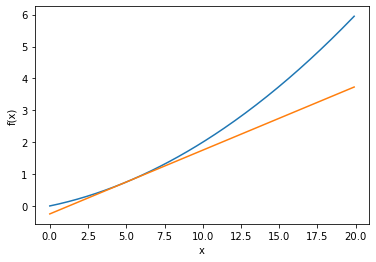

In [8]:
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

### 4.3.3 偏微分

2変数関数 $f(x_0, x_1) = x_0^2 + x_1^2$ について、

$x_0 = 3, x_1 = 4$ のときの $x_0, x_1$に対する偏微分を求めましょう。

ここでは、偏微分する変数以外の変数は予め代入して関数を作成し、計算します。

(1) $\frac{\partial f}{\partial x_0}$ の計算

In [9]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

(2) $\frac{\partial f}{\partial x_1}$ の計算

In [10]:
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 4.4 勾配

次に$x_0$ と $x_1$ の偏微分をまとめて計算することを考えます。

そこで、すべての変数の偏微分をベクトルとしてまとめた"勾配"を導入します。

具体的には $(\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1})$ とまとめることで計算を行います。

まずは、勾配を定義してみましょう。

In [11]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)  # xと同じ形状で、その要素が全て0の配列を生成
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)の計算
        
        x[idx] = tmp_val - h 
        fxh2 = f(x)  # f(x-h)の計算
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val  # 値を元に戻す
        
    return grad

多次元配列(バッチ処理))を含めるため、先の関数を以下の様に修正します。

In [12]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

ここで、$f(x_0, x_1) = x_0^2 + x_1^2$ について、関数を定義します。

In [13]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)  ##勾配の図を描くために、2次限配列に対応

続いて、点 $(3, 4)$ 、$(0, 2)$ 、$(3, 0)$ での勾配を求めます。

In [14]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [15]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [16]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

勾配の全体像はどのようになっているでしょうか？

$f(x_0, x_1) = x_0^2 + x_1^2$ の勾配の結果にマイナスを付けたベクトルとして図示してみます。

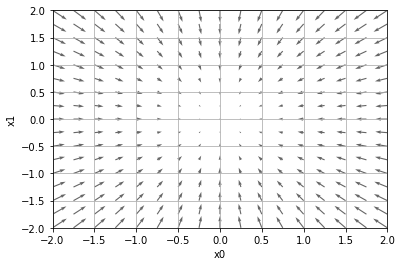

In [17]:
def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y


if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()

    grad = numerical_gradient(function_2, np.array([X, Y]).T).T

    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")  # 勾配にマイナスを付けている
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.show()


この例では、勾配が一番低い場所を示しています。(他の例では必ずしも勾配が一番低い場所を示すわけではないですが...)

勾配は、各地点において低くなる方向を指します。すなわち、各場所において"関数を最も減らす方向"となります。

### 4.4.1 勾配法

概要で損失関数の最小値を探すために、"勾配降下法"を用いると述べました。

(それは、4.3.1 微分の章で述べた通り、損失関数は解析的に微分が求められないことが多いためです。)

勾配降下法とは、現在の場所から勾配方向(関数を減らす方向)に一定の距離だけ進むことを繰り返すことで、

パラメータを修正して関数の値を徐々に減らす方法です。

パラメータ $\mathrm{W}$ が以下のように与えられた場合、対応する勾配降下法を数式で表すと次のようになります。

$$\mathrm{W} =
\begin{pmatrix}
w_{11} & w_{12}\\
\end{pmatrix}$$

$$\mathrm{W} - \frac{\partial L}{\partial \mathrm{W}} =
\begin{pmatrix}
w_{11} - \eta\frac{\partial L}{\partial w_{11}} & w_{12} - \eta\frac{\partial L}{\partial w_{12}}\\
\end{pmatrix}$$

$\eta$ はニューラルネットワークの学習においては、"学習率"と呼ばれます。

これは、前もって与えるハイパーパラメータで、適切に与えてあげる必要があります。

以下に、勾配降下法を定義します。

In [18]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    # lrは学習率、step_numは勾配法による繰り返しの数
    x = init_x  # xの初期値
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)  # 勾配を求める
        x -= lr * grad  # パラメータの修正

    return x, np.array(x_history)

$f(x_0, x_1) = x_0^2 + x_1^2$ の最小値を勾配降下法で求めてみます。

In [19]:
init_x = np.array([-3.0, 4.0]) # 初期値

gradient_descent(function_2, init_x, lr=0.1, step_num=10)

(array([-0.32212255,  0.42949673]),
 array([[-3.        ,  4.        ],
        [-2.4       ,  3.2       ],
        [-1.92      ,  2.56      ],
        [-1.536     ,  2.048     ],
        [-1.2288    ,  1.6384    ],
        [-0.98304   ,  1.31072   ],
        [-0.786432  ,  1.048576  ],
        [-0.6291456 ,  0.8388608 ],
        [-0.50331648,  0.67108864],
        [-0.40265318,  0.53687091]]))

パラメータの変化をプロットしてみます。

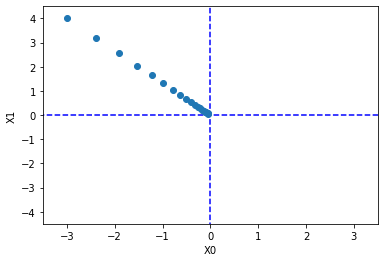

In [20]:
init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

$(0, 0)$ に収束していることが分かります。

ここで、学習率が大きすぎる例と、小さすぎる例についても見てみましょう。

In [21]:
#学習率が大きすぎる例
init_x = np.array([-3.0, 4.0])    

lr = 10,0 # 学習率100倍
step_num = 20
gradient_descent(function_2, init_x, lr=lr, step_num=10)

(array([-2.58984259e+13,  4.00000000e+00]),
 array([[-3.00000000e+00,  4.00000000e+00],
        [ 5.70000000e+01,  4.00000000e+00],
        [-1.08300000e+03,  4.00000000e+00],
        [ 2.05770000e+04,  4.00000000e+00],
        [-3.90963005e+05,  4.00000000e+00],
        [ 7.42829664e+06,  4.00000000e+00],
        [-1.41137328e+08,  4.00000000e+00],
        [ 2.68126267e+09,  4.00000000e+00],
        [-5.10275373e+10,  4.00000000e+00],
        [ 9.45119663e+11,  4.00000000e+00]]))

In [22]:
#学習率が小さすぎる例
init_x = np.array([-3.0, 4.0])    

lr = 1e-10 # 学習率10億分の1倍
step_num = 20
gradient_descent(function_2, init_x, lr=lr, step_num=10)

(array([-2.99999999,  3.99999999]),
 array([[-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  4.        ],
        [-3.        ,  3.99999999],
        [-3.        ,  3.99999999],
        [-2.99999999,  3.99999999]]))

学習率が大きすぎると発散、小さすぎるとほとんど更新されていないことが分かります。

学習率は適切な値に設定することが重要であるといえます。

### 4.4.2 ニューラルネットワークに対する勾配

簡単なニューラルネットワークを使って、勾配を求めてみます。

まずは、SimpleNetのクラスを定義します。

In [23]:
class simpleNet:
    # (2×3)のパラメータの初期値
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化

    # ソフトマックス関数で出力する前の値
    def predict(self, x):
        return np.dot(x, self.W)

    # 損失関数を求める
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

生成したパラメータを確認します。

In [24]:
net = simpleNet() #インスタンスの作成
print(net.W)

[[-0.04658378 -0.55181916  0.33652638]
 [-1.71750264 -1.34356032 -0.97261161]]


入力値 $x$ と正解ラベル $t$ を定義して勾配を求めます。

In [25]:
x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t) # lambdaで関数を生成
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.17344385  0.34179384 -0.51523769]
 [ 0.26016578  0.51269076 -0.77285654]]


## 4.5 学習アルゴリズムの実装

4.4章までのことを踏まえて、ニューラルネットの学習を実装します。

以下の3つの手順を繰り返すことで、学習を行います。

1. ミニバッチ(データをランダム抽出)、2. 勾配の算出、3. パラメータの更新

この方法は、無作為に選ばれているデータを使用することから、"確立的勾配降下法(SGD)"と呼ばれます。

### 4.5.1 2層ニューラルネットワークのクラス

まず、2層ニューラルネットワークを、ひとつのクラスとして定義します。

In [26]:
class TwoLayerNet:

    #重みの初期化
    # input_sizeは入力値の大きさ、hidden_sizeは1層目の数、output_sizeは2層目の数
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}  # ディクショナリ型
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)  # 1層目の重み
        self.params['b1'] = np.zeros(hidden_size)  # 1層目のバイアス
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)  # 2層目の重み
        self.params['b2'] = np.zeros(output_size)  # 2層目のバイアス

    #認識を行う
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    # 認識精度を求める(正解率)
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # パラメータに対する勾配を求める 
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}  # ディクショナリ型
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])  # 1層目の重みの勾配
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])  # 1層目のバイアスの勾配
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])  # 2層目の重みの勾配
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])  # 2層目のバイアスの勾配
        
        return grads
    # 高速に勾配を求める    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

パラメータの形状がどのようになるか、確認しましょう。

In [27]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


続いて、勾配の形状についても確認します。(このコードは時間がかかるので注意してください)

In [28]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


### 4.5.2 ミニバッチ学習の実装　4.5.3 テストデータで評価

mnistのデータを使って、ミニバッチ学習とテストデータでの評価を行います。

まずは、データの読み込みとインスタンスの作成を行います。

In [29]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

続いて、ハイパーパラメータを設定します。

In [30]:
iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100  # ミニバッチサイズ
learning_rate = 0.1  # 学習率

続いて、学習データとテストデータそれぞれの正解率を格納するリストを作成します。

In [31]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

ただし、正解率の計算は、"1エポックごと"に行うことにします。

1エポックは、学習において訓練データを使い切ったときの回数に対応します。

例えば、10000個の訓練データに対して100個のミニバッチで学習する場合、

確立的勾配降下法を100回繰り返すことが1エポックになります。

In [32]:
iter_per_epoch = max(train_size / batch_size, 1)

それでは、実際に実装して、テストデータで評価してみましょう。

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.8007, 0.8022
train acc, test acc | 0.87575, 0.8797
train acc, test acc | 0.89595, 0.8995
train acc, test acc | 0.9061833333333333, 0.9079
train acc, test acc | 0.9134666666666666, 0.9158
train acc, test acc | 0.9190333333333334, 0.9211
train acc, test acc | 0.9242666666666667, 0.9271
train acc, test acc | 0.9270666666666667, 0.9278
train acc, test acc | 0.9316166666666666, 0.9321
train acc, test acc | 0.9348333333333333, 0.9342
train acc, test acc | 0.9365166666666667, 0.937
train acc, test acc | 0.9407333333333333, 0.9395
train acc, test acc | 0.9423666666666667, 0.9412
train acc, test acc | 0.9454166666666667, 0.9435
train acc, test acc | 0.94675, 0.9438
train acc, test acc | 0.9486166666666667, 0.9472


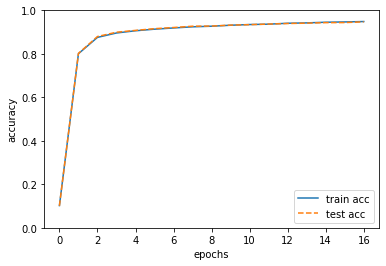

In [33]:
for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

学習が進むにつれて、訓練データとテストデータともに、認識精度が向上しています。

そのため、今回の学習では過学習が起きていないことが分かります。

## 4.6 まとめ

・ニューラルネットを使って、訓練データで学習を行い、テストデータで評価する方法を学んだ

・学習には、損失関数を指標として、損失関数の値が小さくなるように、パラメータを更新する

・パラメータの更新には、勾配降下法を利用する

・数値微分によって、パラメータの勾配を求めることができる